# AutoML Image Classification: With Rotation (Fashion MNIST)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/rotation.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node
    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(GaussianNoise("mean", "std"))
    # err_img_node.addfilter(Clip("min_val", "max_val"))
    # return err_root_node

In [5]:
def get_err_params_list(data):
    angle_steps = np.linspace(0, 180, num=6)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    # return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*6
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import torch
        print(torch.cuda.get_device_name(0))
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=32, min_mem_size_GB=128, max_mem_size_GB=128)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        print(best_pipeline)
        h2o.remove_all()
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=params["augment"], path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": True
        # },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        # err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpytk_dgdf

  JVM stdout: /wrk/users/thalvari/tmpytk_dgdf/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpytk_dgdf/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 8 days
H2O cluster name:,#486712019
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191216_023235']

H2O session _sid_89cb closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.9

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphxzjakok

  JVM stdout: /wrk/users/thalvari/tmphxzjakok/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphxzjakok/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 8 days
H2O cluster name:,#690739191
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191216_083454']

H2O session _sid_a039 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.9

 17%|█▋        | 1/6 [12:04:54<60:24:33, 43494.68s/it]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxt7fbcoo

  JVM stdout: /wrk/users/thalvari/tmpxt7fbcoo/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxt7fbcoo/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#278133920
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191216_143727', 'XGBoost_2_AutoML_20191216_143727', 'XGBoost_1_AutoML_20191216_143727', 'DRF_1_AutoML_20191216_143727', 'XGBoost_3_AutoML_20191216_143727', 'GLM_grid_1_AutoML_20191216_143727_model_1']

H2O session _sid_abc3 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.856

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp6l9mf2ek

  JVM stdout: /wrk/users/thalvari/tmp6l9mf2ek/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp6l9mf2ek/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#395544727
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191216_204031']

H2O session _sid_9df7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.568

 33%|███▎      | 2/6 [24:10:02<48:19:54, 43498.52s/it]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqdkzet16

  JVM stdout: /wrk/users/thalvari/tmpqdkzet16/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqdkzet16/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#222057605
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191217_024235', 'XGBoost_2_AutoML_20191217_024235', 'XGBoost_1_AutoML_20191217_024235', 'XGBoost_3_AutoML_20191217_024235', 'GLM_grid_1_AutoML_20191217_024235_model_1']

H2O session _sid_ac92 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.826

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphjo1oqvk

  JVM stdout: /wrk/users/thalvari/tmphjo1oqvk/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphjo1oqvk/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#292257365
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191217_084457']

H2O session _sid_81d8 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.358

 50%|█████     | 3/6 [36:14:46<36:14:42, 43494.22s/it]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpurpgx5_5

  JVM stdout: /wrk/users/thalvari/tmpurpgx5_5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpurpgx5_5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#250172364
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191217_144719', 'XGBoost_2_AutoML_20191217_144719', 'XGBoost_1_AutoML_20191217_144719']

H2O session _sid_9d21 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.809

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmprtya_unw

  JVM stdout: /wrk/users/thalvari/tmprtya_unw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmprtya_unw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#555060815
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191217_204842']

H2O session _sid_b6a3 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.261

 67%|██████▋   | 4/6 [48:18:17<24:08:58, 43469.28s/it]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpuump5ock

  JVM stdout: /wrk/users/thalvari/tmpuump5ock/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpuump5ock/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#1003016356
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191218_025049', 'XGBoost_2_AutoML_20191218_025049', 'XGBoost_1_AutoML_20191218_025049', 'XGBoost_3_AutoML_20191218_025049', 'GLM_grid_1_AutoML_20191218_025049_model_1']

H2O session _sid_aae7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.793

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp6ze8im97

  JVM stdout: /wrk/users/thalvari/tmp6ze8im97/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp6ze8im97/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#706602033
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191218_085245']

H2O session _sid_8f28 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.231

 83%|████████▎ | 5/6 [60:22:18<12:04:20, 43460.97s/it]

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp3rd9_408

  JVM stdout: /wrk/users/thalvari/tmp3rd9_408/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp3rd9_408/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 11 days
H2O cluster name:,#605941648
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191218_145451', 'XGBoost_2_AutoML_20191218_145451', 'XGBoost_1_AutoML_20191218_145451', 'XGBoost_3_AutoML_20191218_145451', 'GLM_grid_1_AutoML_20191218_145451_model_1']

H2O session _sid_9afe closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.787

Tesla V100-PCIE-32GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpcn6hp0gj

  JVM stdout: /wrk/users/thalvari/tmpcn6hp0gj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpcn6hp0gj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 11 days
H2O cluster name:,#986990309
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['XGBoost_1_AutoML_20191218_205732']

H2O session _sid_8842 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.237

100%|██████████| 6/6 [72:27:09<00:00, 43469.96s/it]   

100%|██████████| 6/6 [72:27:09<00:00, 43471.66s/it]

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.9,1,3.821,0.718,21743.1
36,0.856,1,4.94,0.52,21783.2
72,0.826,0.999,5.044,0.524,21742.8
108,0.809,0.999,5.001,0.552,21682.5
144,0.793,0.998,4.841,0.54,21714.3
180,0.787,0.998,4.908,0.538,21760.1


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,XGBoost_1_AutoML_20191216_023235,nan,nan,nan,nan,nan
36,StackedEnsemble_AllModels_AutoML_20191216_143727,XGBoost_2_AutoML_20191216_143727,XGBoost_1_AutoML_20191216_143727,DRF_1_AutoML_20191216_143727,XGBoost_3_AutoML_20191216_143727,GLM_grid_1_AutoML_20191216_143727_model_1
72,StackedEnsemble_AllModels_AutoML_20191217_024235,XGBoost_2_AutoML_20191217_024235,XGBoost_1_AutoML_20191217_024235,XGBoost_3_AutoML_20191217_024235,GLM_grid_1_AutoML_20191217_024235_model_1,nan
108,StackedEnsemble_AllModels_AutoML_20191217_144719,XGBoost_2_AutoML_20191217_144719,XGBoost_1_AutoML_20191217_144719,nan,nan,nan
144,StackedEnsemble_AllModels_AutoML_20191218_025049,XGBoost_2_AutoML_20191218_025049,XGBoost_1_AutoML_20191218_025049,XGBoost_3_AutoML_20191218_025049,GLM_grid_1_AutoML_20191218_025049_model_1,nan
180,StackedEnsemble_AllModels_AutoML_20191218_145451,XGBoost_2_AutoML_20191218_145451,XGBoost_1_AutoML_20191218_145451,XGBoost_3_AutoML_20191218_145451,GLM_grid_1_AutoML_20191218_145451_model_1,nan


'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.9,1,3.821,0.718,21746.7
36,0.568,1,4.94,0.52,21718.2
72,0.358,1,5.044,0.524,21735.2
108,0.261,1,5.001,0.552,21722.4
144,0.231,1,4.841,0.54,21721.4
180,0.237,1,4.908,0.538,21724.8


max_angle,pipe_0
0,XGBoost_1_AutoML_20191216_083454
36,XGBoost_1_AutoML_20191216_204031
72,XGBoost_1_AutoML_20191217_084457
108,XGBoost_1_AutoML_20191217_204842
144,XGBoost_1_AutoML_20191218_085245
180,XGBoost_1_AutoML_20191218_205732


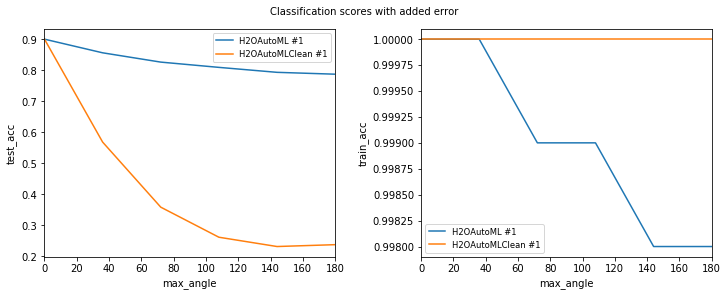

In [11]:
print_results_by_model(df,
    ["train_labels", "test_labels"],
    # ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="max_angle",
    # err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)